# ACF and PACF

In [20]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import pacf

Let us illustrate the concepts of ACF and PACF through the sunspots dataset. 

        0     1    2  3  4
0  1700.5   8.3 -1.0 -1  1
1  1701.5  18.3 -1.0 -1  1
2  1702.5  26.7 -1.0 -1  1
3  1703.5  38.3 -1.0 -1  1
4  1704.5  60.0 -1.0 -1  1


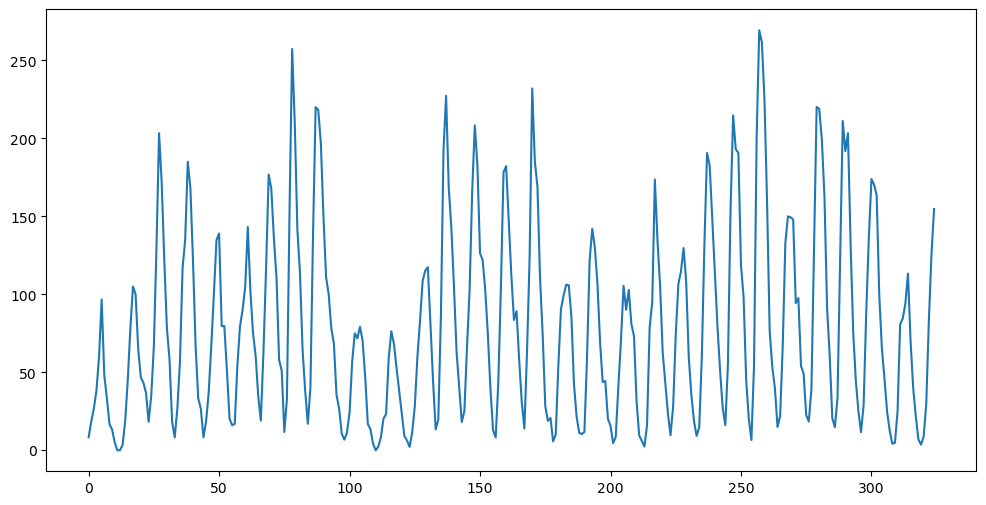

In [21]:
sunspots = pd.read_csv('SN_y_tot_V2.0.csv', header=None, sep=';')
print(sunspots.head())

y = sunspots.iloc[:, 1].values
n = len(y)
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()

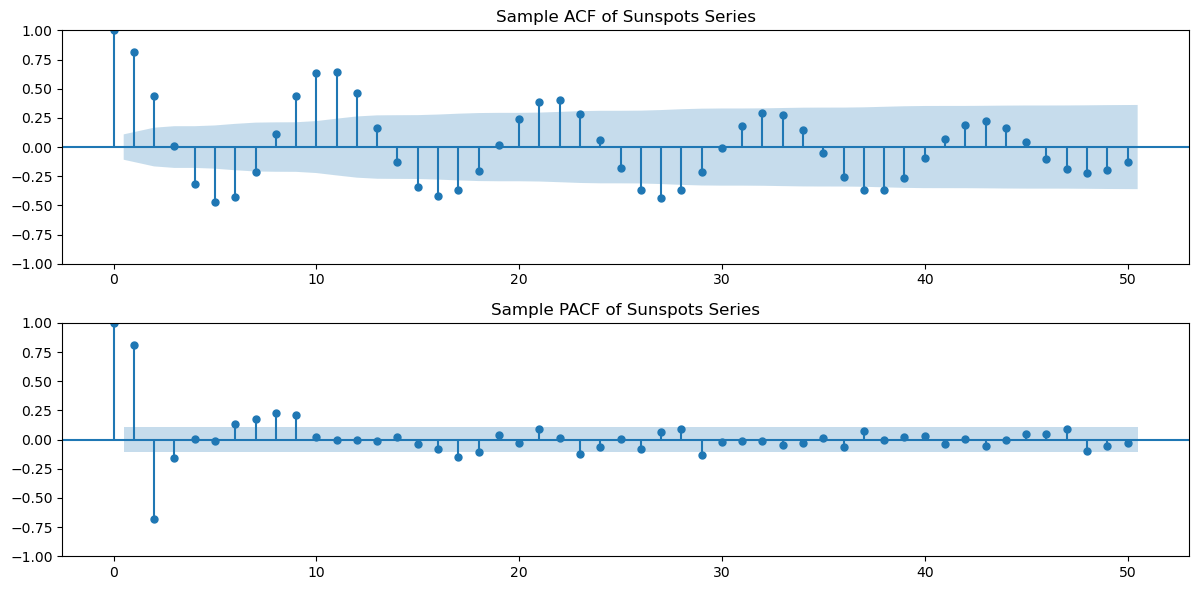

In [22]:
h_max = 50
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

plot_acf(y, lags = h_max, ax = axes[0])
axes[0].set_title("Sample ACF of Sunspots Series")

plot_pacf(y, lags = h_max, ax = axes[1])
axes[1].set_title("Sample PACF of Sunspots Series")

plt.tight_layout()
plt.show()

The sample ACF has an oscillatory pattern, and the sample autocorrelations only become negligible after lag 12 (even though sample autocorrelations at lags 15, 16, 17 also seem nontrivial). This suggests that MA models may not be appropriate for this dataset. The partial PACF clearly has two big spikes at lags 1 and 2, and then mostly small. This suggests that an AR(2) model might be appropriate. One can also consider the sample PACF at lags 7, 8, 9 to be nonnegligible. In this case, we can try to fit AR(9) to the data. 

## Calculation of PACF

Let us see how the PACF is calculated. The definition of PACF($h$) is the estimate $\hat{\phi}_h$ of $\phi_h$ when the AR($h$) model is fit to the data.  Let us check if this is indeed the case. 

In [ ]:
def sample_pacf(y, p_max):
    pautocorr = []
    for p in range(1, p_max + 1):
        armd = AutoReg(y, lags = p).fit() # fitting the AR(p) model
        phi_p = armd.params[-1] # taking the last estimated coefficient
        pautocorr.append(phi_p)
    return pautocorr

Let us now compare these values with the values given by an inbuilt function for pacf. 

In [24]:
p_max = 50
pacf_vals = sample_pacf(y, p_max)

pacf_vals_sm = pacf(y, nlags=p_max, method='ols') # these pacf values start with the value 1 at lag 0. 
print(np.column_stack([pacf_vals, pacf_vals_sm[1:]])) 

[[ 0.81814243  0.81814243]
 [-0.69646032 -0.69646032]
 [-0.14551566 -0.14551566]
 [ 0.01078091  0.01078091]
 [-0.00988486 -0.00988486]
 [ 0.13721057  0.13721057]
 [ 0.20129653  0.20129653]
 [ 0.22159369  0.22159369]
 [ 0.21768779  0.21768779]
 [ 0.01979271  0.01979271]
 [ 0.01220908  0.01220908]
 [-0.01159196 -0.01159196]
 [ 0.00638536  0.00638536]
 [ 0.04363913  0.04363913]
 [-0.05535382 -0.05535382]
 [-0.07389671 -0.07389671]
 [-0.16269894 -0.16269894]
 [-0.12338723 -0.12338723]
 [ 0.05099077  0.05099077]
 [-0.02507587 -0.02507587]
 [ 0.09908343  0.09908343]
 [ 0.01560164  0.01560164]
 [-0.12666585 -0.12666585]
 [-0.07148407 -0.07148407]
 [ 0.00513059  0.00513059]
 [-0.11203047 -0.11203047]
 [ 0.05033772  0.05033772]
 [ 0.07062661  0.07062661]
 [-0.13345508 -0.13345508]
 [-0.0234795  -0.0234795 ]
 [-0.00607123 -0.00607123]
 [-0.01538124 -0.01538124]
 [-0.02963781 -0.02963781]
 [-0.00909349 -0.00909349]
 [-0.01330015 -0.01330015]
 [-0.05143092 -0.05143092]
 [ 0.06104478  0.06104478]
 

See that the two sets of sample pacf values coincide exactly. 

# Regression and Partial Correlation

As already mentioned, the sample pacf at lag $h$ is defined as the estimate $\hat{\phi}_h$ of $\phi_h$ when the AR($h$) model is fit to the data. From this definition, it makes sense that these values can be used for AR model selection. However why does this definition have the name "partial correlation". In statistics, the partial correlation between two variables $y, x$ given a bunch of other variables $z_1, \dots, z_k$ is defined as the correlation between the residuals $e^{y \mid z_1, \dots, z_k}$ and $e^{x \mid z_1, \dots, z_k}$. Below we calculate the partial correlation in terms of residuals, and then see how it is related to our definition of the sample pacf. 

Let us first fix a value of $p$ and then compute the sample PACF at lag $p$ directly (without using inbuilt library functions). 

In [ ]:
p = 9 # fix a value of p
yreg = y[p: ] # these are the response values in the autoregression
Xmat = np.ones((n - p, 1)) # this will be the design matrix (X) in the autoregression
for j in range(1, p + 1):
    col = y[p - j:n - j].reshape(-1, 1)
    Xmat = np.column_stack([Xmat, col])
armod = sm.OLS(yreg, Xmat).fit()
print(armod.params)

pacf_lag_p = armod.params[-1]
print(pacf_lag_p)

[ 1.27820089e+01  1.17199169e+00 -4.20714239e-01 -1.35002174e-01
  1.01279088e-01 -6.66442555e-02  1.83774039e-03  1.51264798e-02
 -4.29674964e-02  2.17687794e-01]
0.2176877941518983


Here the response variable yreg denotes $y_t, t = p+1, \dots, n$. The first column of Xmat is the column of ones, the second column is $y_{t-1}, t = p+1, \dots, n$, third column is $y_{t-2}, t = p+1, \dots, n$ and so on with the last column being $y_{t-p}, t = p+1, \dots, n$. 

In [26]:
print(np.column_stack([yreg, Xmat]))
print(y)

[[ 13.3   1.   16.7 ...  26.7  18.3   8.3]
 [  5.    1.   13.3 ...  38.3  26.7  18.3]
 [  0.    1.    5.  ...  60.   38.3  26.7]
 ...
 [ 83.2   1.   29.6 ...  69.8 113.3  94. ]
 [125.5   1.   83.2 ...  39.8  69.8 113.3]
 [154.7   1.  125.5 ...  21.7  39.8  69.8]]
[  8.3  18.3  26.7  38.3  60.   96.7  48.3  33.3  16.7  13.3   5.    0.
   0.    3.3  18.3  45.   78.3 105.  100.   65.   46.7  43.3  36.7  18.3
  35.   66.7 130.  203.3 171.7 121.7  78.3  58.3  18.3   8.3  26.7  56.7
 116.7 135.  185.  168.3 121.7  66.7  33.3  26.7   8.3  18.3  36.7  66.7
 100.  134.8 139.   79.5  79.7  51.2  20.3  16.   17.   54.   79.3  90.
 104.8 143.2 102.   75.2  60.7  34.8  19.   63.  116.3 176.8 168.  136.
 110.8  58.   51.   11.7  33.  154.2 257.3 209.8 141.3 113.5  64.2  38.
  17.   40.2 138.2 220.  218.2 196.8 149.8 111.  100.   78.2  68.3  35.5
  26.7  10.7   6.8  11.3  24.2  56.7  75.   71.8  79.2  70.3  46.8  16.8
  13.5   4.2   0.    2.3   8.3  20.3  23.2  59.   76.3  68.3  52.9  38.5
  24.2   9

Now let us calculate the same sample PACF value using partial correlation. Specifically, we will calculate the partial correlation between the variables $y_t$ and $y_{t-p}$ given all the intervening variables $y_{t-1}, y_{t-2}, \dots, y_{t-p+1}$. For this, we first need to calculate the residual of $y_t$ given $y_{t-1}, \dots, y_{t-p+1}$ as well as the residual of $y_{t-p}$ given $y_{t-1}, \dots, y_{t-p+1}$. 

The residual of $y_t$ given $y_{t-1}, \dots, y_{t-p+1}$ is calculated as follows. 

In [ ]:
armod1 = sm.OLS(yreg, Xmat[:, :-1]).fit()
res_y = armod1.resid

The residual of $y_{t-p}$ given $y_{t-1}, \dots, y_{t-p+1}$ is calculated as follows. 

In [ ]:
armod2 = sm.OLS(Xmat[:, -1], Xmat[:, :-1]).fit()
res_x = armod2.resid

The sample correlation between these two residuals is the sample PACF at lag $p$: 

In [29]:
pcorr = np.corrcoef(res_y, res_x)[0, 1]
print(pcorr, pacf_lag_p)

0.21950061866415008 0.2176877941518983


Note that this is basically the same as the Sample PACF at lag $p$. The minor discrepancy occurs because the two residuals do not have exactly the same variance. More precisely, the regression coefficient $\hat{\beta}_j$ in a multiple linear regression of $y$ on a set of covariates $x_1, \dots, x_k$ satisfies the following formula: 
\begin{equation*}
  \hat{\beta}_j = \text{corr}(e^{y \mid x_k, k \neq j}, e^{x_j \mid x_k, k \neq j}) \sqrt{\frac{\text{var}(e^{y \mid x_k, k \neq j})}{\text{var}(e^{x_j \mid x_k, k \neq j})}}
\end{equation*}

In [30]:
var_res_y = np.var(res_y)
var_res_x = np.var(res_x)
print(var_res_y, var_res_x)

570.4359419392475 579.9762661182705


These residual variances are similar but not exactly the same. This explains why the correlation between the residuals does not exactly equal the fitted regression coefficient $\hat{\phi}_p$. But if we multiply the partial correlation by the ratio of the standard deviations, we recover the sample pacf at lag p (i.e., $\hat{\phi}_p$) exactly. 

In [31]:
reg_coeff = pcorr * np.sqrt(var_res_y/var_res_x)
print(reg_coeff, pacf_lag_p)

0.2176877941518987 0.2176877941518983


## Fitting AR(9) and AR(2) to the Sunspots Data

Based on the PACF plot, the two models which make sense for the sunspots data are AR(2) and AR(9). Let us fit both of these models to the data. 

In [ ]:
armd_2 = AutoReg(y, lags=2).fit() 
armd_9 = AutoReg(y, lags=9).fit() 

In [ ]:
k = 200
fcast_9 = armd_9.get_prediction(start=n, end=n+k-1)
fcast_mean_9 = fcast_9.predicted_mean

fcast_2 = armd_2.get_prediction(start=n, end=n+k-1)
fcast_mean_2 = fcast_2.predicted_mean

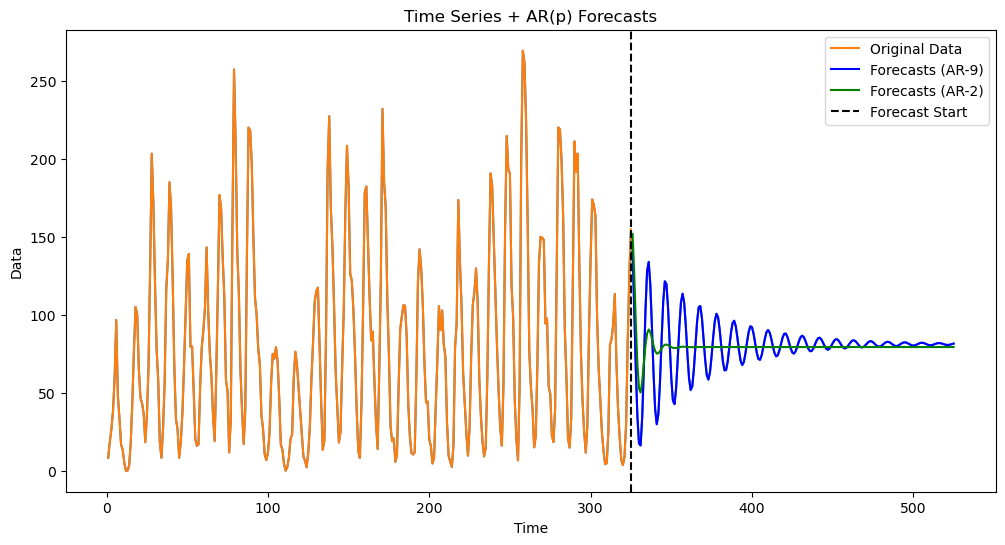

In [35]:
yhat_9 = np.concatenate([y, fcast_mean_9])
yhat_2 = np.concatenate([y, fcast_mean_2])

plt.figure(figsize=(12, 6))
time_all = np.arange(1, n + k + 1)
plt.plot(time_all, yhat_9, color='C0')
plt.plot(range(1, n + 1), y, label='Original Data', color='C1')
plt.plot(range(n + 1, n + k + 1), fcast_mean_9, label='Forecasts (AR-9)', color='blue')
plt.plot(range(n + 1, n + k + 1), fcast_mean_2, label='Forecasts (AR-2)', color='green')
plt.axvline(x=n, color='black', linestyle='--', label='Forecast Start')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Time Series + AR(p) Forecasts')
plt.legend()
plt.show()

Visually the AR(9) predictions appear better at least for the initial few predictions. 

## AR models and Stationarity

For an AR(p) model $y_t = \phi_0 + \phi_1 y_{t-1} + \dots + \phi_p y_{t-p} + \epsilon_t$, its characteristic polynomial is given by $\phi(z) = 1 - \phi_1 z - \phi_2 z^2 - \dots - \phi_p z^p$. This is a polynomial of degree $p$ so it has $p$ roots $z_1, \dots, z_p$. Some of the roots may be complex (even though $\phi_1, \dots, \phi_p$ are all real). If the modulus $|z_j|$ of $z_j$ is strictly larger than 1 for every $j$, then the corresponding AR(p) model is called **causal and stationary**. 

Let us check stationary of the fitted AR(2) and AR(9) models that we just fitted to the sunspots dataset. 

In [36]:
print(armd_2.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  325
Model:                     AutoReg(2)   Log Likelihood               -1505.524
Method:               Conditional MLE   S.D. of innovations             25.588
Date:                Thu, 10 Apr 2025   AIC                           3019.048
Time:                        15:55:25   BIC                           3034.159
Sample:                             2   HQIC                          3025.080
                                  325                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.4561      2.372     10.308      0.000      19.806      29.106
y.L1           1.3880      0.040     34.685      0.000       1.310       1.466
y.L2          -0.6965      0.040    -17.423      0.0

The roots and their modulus are actually given as part of the summary output. We can also compute them as follows. 

In [ ]:
# characteristic polynomial
coeffs = [(-1) * armd_2.params[2], (-1) * armd_2.params[1], 1] # these are the coefficients of the characteristic polynomial
roots = np.roots(coeffs) # these are the roots of the characteristic polynomial
print(coeffs)
print(roots)
magnitudes = np.abs(roots)
print(magnitudes)

[np.float64(0.6964603222695152), np.float64(-1.3880327164912336), 1]
[0.99649088+0.66546067j 0.99649088-0.66546067j]
[1.19826206 1.19826206]


As the magnitude of both roots is strictly larger than 1, this is a stationary AR(2) model (it is also causal). 

Now let us check whether the fitted AR(9) model is causal and stationary. 

In [38]:
print(armd_9.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  325
Model:                     AutoReg(9)   Log Likelihood               -1443.314
Method:               Conditional MLE   S.D. of innovations             23.301
Date:                Thu, 10 Apr 2025   AIC                           2908.628
Time:                        15:55:25   BIC                           2949.941
Sample:                             9   HQIC                          2925.132
                                  325                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7820      4.002      3.194      0.001       4.938      20.626
y.L1           1.1720      0.055     21.338      0.000       1.064       1.280
y.L2          -0.4207      0.086     -4.905      0.0

All roots have magnitudes strictly larger than 1 so this is also a causal and stationary  model. These roots and their magnitudes can also be computed as follows. 

In [39]:
# Extract coefficients for the characteristic polynomial
coeffs = [(-1) * armd_9.params[i] for i in range(9, 0, -1)]  # Reverse order: lags 9→1
coeffs.append(1)
roots = np.roots(coeffs)
magnitudes = np.abs(roots)
print(magnitudes)

[1.30855577 1.30855577 1.31416814 1.31416814 1.17555576 1.17555576
 1.07010924 1.02490237 1.02490237]


These magnitudes coincide with the values in the table although the order in which they are listed in the table may be different (there is no default ordering for displaying the roots). 